## 1. 批量下载全国雷达拼图资料

图片地址是这样的格式：http://image.data.cma.cn/vis/RAD__B0_CR/20220616/Z_RADA_C_BABJ_20220616152400_P_DOR_RDCP_R_ACHN.PNG
下载时只需要修改地址里的日期即可

In [1]:
import datetime 
import urllib.request as request
from urllib.request import urlretrieve

opener = request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')] #这一行不加可能会有问题
request.install_opener(opener)

# set time (UTC) for downloading. 
start = datetime.datetime(2022, 4, 25, 6)
end   = datetime.datetime(2022, 4, 25, 8)
delta = datetime.timedelta(minutes=6) 
dd = start
while dd <= end:
    img_url = "http://image.data.cma.cn/vis/RAD__B0_CR/"+dd.strftime("%Y%m%d")+"/Z_RADA_C_BABJ_"+dd.strftime("%Y%m%d%H%M")+"00_P_DOR_RDCP_R_ACHN.PNG"
   # img_url= f'http://image.data.cma.cn/vis/RAD__B0_CR/20220616/Z_RADA_C_BABJ_20220616152400_P_DOR_RDCP_R_ACHN.PNG'
    file_name = img_url[-50:]
    try:
        urlretrieve(img_url, file_name)
    except Exception:
        print(dd.strftime("%Y%m%d%H%M")+": Download failed. File May not exist.")
    else:
        print(dd.strftime("%Y%m%d%H%M")+": Download sucessfully ^_^")
    dd += delta

202204250800: Download sucessfully ^_^


## 2. 将图片准备成dbz的图像或数据

提取出图片的回波信息，图像信息存储为新的图像，回波数据存储为.npy数据，下一次还要用就不需要重复操作了。

2.1 提取回波信息，去除无关的地图文字等。方法来自于clarmy吱声公众号：https://mp.weixin.qq.com/s/SE4oVyVD9WVkgRhmjBC5tA，写得非常细致。

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.spatial import KDTree
import os
import numpy as np
print(os.getcwd())
import webcolors
import datetime 
import h5py

e:\xiaowu\extrapolation


In [21]:
#右下角图例显示的13个色块所表示颜色的编码，可利用MacOS上一colorSLurp的取色器取色
COLORS = [
    '#AD90F0',
    '#9600B4',
    '#FF00F0',
    '#C00001',
    '#D60100',
    '#FF0200',
    '#FF9000',
    '#E7C000',
    '#FEFF00',
    '#009000',
    '#00D800',
    '#00ECEC',
    '#01A0F6'
]
#获取图例的像素位置区域范围
left_x = 955
upper_y = 665
right_x = 973
lower_y = 858
#把颜色的hex码转换为RGB整数值
colors_arrays = np.array([list(webcolors.hex_to_rgb(c)) for c in COLORS])
print(colors_arrays)

cm_user=np.array(colors_arrays[::-1])/255.0
icmap=colors.ListedColormap(cm_user,name='my_color') 
plt.register_cmap(cmap=icmap)

[[173 144 240]
 [150   0 180]
 [255   0 240]
 [192   0   1]
 [214   1   0]
 [255   2   0]
 [255 144   0]
 [231 192   0]
 [254 255   0]
 [  0 144   0]
 [  0 216   0]
 [  0 236 236]
 [  1 160 246]]


In [24]:
dBZ_levels = np.arange(72.5, 7.5, -5) #由图右下角的colorbar
def pre_process(pic_file):
    '''
    加载图片,生成去除地理信息后的纯dBZ图片,并将对应的dBZ存到npy文件中
    '''
    
    #加载图片文件
    pic_name = pic_file[-36:-24]
    raw_img_array = plt.imread(pic_file)
    #0-255整数形式的RGB数值更为精确和通用，plt.imread读取的颜色为0-1的浮点数，因此转换为int型
    rgb_img_array = (raw_img_array * 255).astype(np.uint8)

    #将底图与dbz颜色分离
    #初始化阶段将原始图片数组分别存入两个数组。
    #存底图的数组为flaw_img_array，由于后期底图的数组主要用于对缝隙的填补，因此使用flaw。
    flaw_img_array = copy.deepcopy(rgb_img_array)
    #存dbz的数组为data_img_array
    data_img_array = copy.deepcopy(rgb_img_array)

    # 方法: 先将图中的dbz剔除掉，得到纯净的底图，然后获取底图带颜色区域的坐标，利用该坐标将底图赋值为白色，从而获取dbz
    # 1. 剔除dbz像素点，提取出底图部分的坐标
    for colors_array in colors_arrays:
        dist = np.sum((rgb_img_array - colors_array) ** 2, axis=2)
        dbz_index = np.where(dist==dist.min())
        flaw_img_array[dbz_index] = np.array([255,255,255])
        flaw_index = np.where(flaw_img_array.sum(axis=2)<255*3) #非白色的坐标位置，即底图的坐标位置 白色的RGB为255 255 255

    # 2. 将底图部分赋值为空白
    data_img_array[flaw_index] = np.array([255,255,255])

    #使用先验信息里的图例位置将图例剪掉
    data_img_array[upper_y:lower_y+1,left_x:right_x+1] = np.array([255,255,255])

    #以上图片中有dBZ裂痕，下面进行填补
    # 1. 获取裂痕坐标
    flaw_yx = np.where(flaw_img_array.sum(axis=2)<255*3) #和方法2中的思路一样
    # 2. create a mask
    mask = np.full(raw_img_array.shape[:2], False)
    mask[flaw_yx] = True
    # 3. use scipy.spatial.KDTree to look for the nearest value to fill the cracks
    flaw_xy = flaw_yx[::-1]
    data_xy = np.where(~mask)[::-1]

    data_points = np.array(data_xy).T
    flaw_points = np.array(flaw_xy).T

    data_img_array[mask] = data_img_array[~mask][KDTree(data_points).query(flaw_points)[1]] #返回值是离查询点最近的点的距离和索引

    #save the image array to png
    plt.imsave("dbz_"+pic_name+".png",np.uint8(data_img_array))

    dBZ_figure = np.empty(shape=(data_img_array.shape[0],data_img_array.shape[1]))
    for n, colors_array in enumerate(colors_arrays):
        dist = np.sum( (data_img_array - colors_array)**2, axis = 2 )
        dbz_index = np.where( (dist == dist.min()) & (dist.min()< 10) )
        dBZ_figure[dbz_index] = dBZ_levels[n]
    
    np.save('dBZ_'+pic_name+'.npy',dBZ_figure) 

2.2 retrieve the dBZ value from image and visualize for a single time

[72.5 67.5 62.5 57.5 52.5 47.5 42.5 37.5 32.5 27.5 22.5 17.5 12.5] (880, 1024, 3)
57.5 0.0


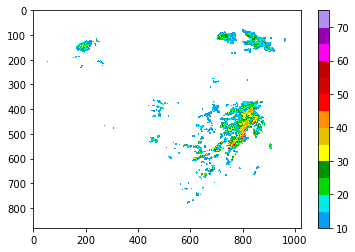

In [50]:
file_name = "E:/xiaowu/extrapolation/pic_ori/dbz_202204250600.png"
img_raw = plt.imread(file_name)
data_img_array = img_raw[:,:,0:3]
data_img_array = (data_img_array * 255).astype(int)

dBZ_levels = np.arange(72.5, 7.5, -5)
print(dBZ_levels,data_img_array.shape)

dBZ_figure = np.empty(shape=(data_img_array.shape[0],data_img_array.shape[1]))
for n, colors_array in enumerate(colors_arrays):
    dist = np.sum( (data_img_array - colors_array)**2, axis = 2 )
    dbz_index = np.where( (dist == dist.min()) & (dist.min()< 10) )
    dBZ_figure[dbz_index] = dBZ_levels[n]

print(dBZ_figure.max(),dBZ_figure.min())
dBZ_figure = np.where(dBZ_figure == 0.0, np.nan , dBZ_figure)
plt.pcolormesh(dBZ_figure,cmap=icmap,vmin = 10, vmax = 75)
plt.gca().invert_yaxis()
plt.colorbar()

2.3 batch operation for the input preparation

In [55]:
path = 'E:/xiaowu/extrapolation/pic_ori/'

start = datetime.datetime(2022, 4, 25, 6)
end   = datetime.datetime(2022, 4, 25, 10)
delta = datetime.timedelta(minutes=6) 
dd = start
while dd <= end:
    file_name = "Z_RADA_C_BABJ_"+dd.strftime("%Y%m%d%H%M")+"00_P_DOR_RDCP_R_ACHN.PNG"
    pre_process(path+file_name)
    dd += delta

## 3. 准备输入数据（t-12至t0时刻的回波图）和验证数据（t1至t+20时刻的回波图）

3.1 set dictionary with timestep indexes

In [4]:
t_begin = datetime.datetime(2022, 4, 25, 7, 00) 
delta = datetime.timedelta(minutes=6) 

t_list = [ t_begin + i*delta for i in range(0,11) ]
eval_idex = {}
for t_0 in t_list:
    # set dictionary with timestep indexes
    # dictionary structure: {"t": [ [t-10, t-9,..., t-1], [t, t+1,...,t+10] ]}
    eval_idex[t_0.strftime("%Y%m%d%H%M")] = [ [int( (t_0 - i*delta).strftime("%Y%m%d%H%M") ) for i in np.arange(10, 0, -1)], \
        [int( (t_0 + i*delta).strftime("%Y%m%d%H%M") ) for i in range(0, 10)] ]

#print(eval_idex.items())
print(eval_idex['202204250800'][1])

[202204250800, 202204250806, 202204250812, 202204250818, 202204250824, 202204250830, 202204250836, 202204250842, 202204250848, 202204250854]


3.2 Load the .npy data or images as input

这里光流法的输入要求是灰度图，因此我们直接读图像对应的反射率数值（之前存储在了.npy文件中），并转化成0-255的数值。

In [5]:
import cv2

path = 'E:/xiaowu/extrapolation/pic_ori/'

t_begin = datetime.datetime(2022, 4, 25, 7, 00)  #0700至0800 选了11个时刻做外推
delta = datetime.timedelta(minutes=6) 

data_dict = {}

t_list = [ t_begin + i*delta for i in range(0,11) ]
for t_0 in t_list:
    data_pre = []
    for i in np.arange(10, 0, -1):
        t_i =  (t_0 - i*delta).strftime("%Y%m%d%H%M") 
        file_name = "dBZ_"+t_i+".npy"
        rgb_img_array = np.load(path+file_name)
        #file_name = "dbz_"+t_i+".png"
        #raw_img_array = cv2.imread(path+file_name)
        #rgb_img_array = cv2.cvtColor(raw_img_array,cv2.COLOR_BGR2GRAY) 
        #print(type(rgb_img_array[1,1]))
        #rgb_img_array = (raw_img_array * 255).astype(np.uint8) #np.array
        #print(rgb_img_array.shape) #第四个通道是透明度 (880, 1024, 4)
        data_pre.append(rgb_img_array)

    data_fcst = []
    for i in range(0, 10):
        t_i =  (t_0 + i*delta).strftime("%Y%m%d%H%M") 
        file_name = "dBZ_"+t_i+".npy"
        rgb_img_array = np.load(path+file_name)
        #file_name = "dbz_"+t_i+".png"
        #raw_img_array = cv2.imread(path+file_name)
        #rgb_img_array = cv2.cvtColor(raw_img_array,cv2.COLOR_BGR2GRAY) 
        data_fcst.append(rgb_img_array)

    data_list = [np.array(data_pre),np.array(data_fcst)]
    
    data_dict[t_0.strftime("%Y%m%d%H%M")] = data_list

In [6]:
raw_img_array = cv2.imread(path+"dbz_202204250648.png")
print(raw_img_array.shape)

(880, 1024, 3)


In [7]:
print(data_dict['202204250700'][0].shape) #pre image 有10个时次
print(data_dict['202204250700'][1].shape) #fcst 也是10个时刻

(10, 880, 1024)
(10, 880, 1024)


3.3 create the ground truth, that is, echo for the lead time t, t+1, ...,   t+9

In [6]:
# create placeholder (or load previously calculated) results
try:
    results
except NameError:
    var_exists = False
else:
    var_exists = True
    del results
    
results = h5py.File("results.h5","w") 

In [7]:
# create ground truth predictions
def ground_truth(data_instance, eval_instance, results_instance):

    results_instance.create_group("/GT/")

    for key in sorted(list(eval_instance.keys())):
        ground_truth = np.array( data_instance[key][1] ) # 1 表示fcst的时刻
        results_instance["/GT/"].create_dataset(key, 
                                                data=ground_truth, 
                                                dtype="float16", 
                                                compression="gzip")         

In [8]:
ground_truth(data_dict, eval_idex, results)

## 4. 运用光流法模型

参考: https://github.com/hydrogo/rainymotion/blob/master/docs/notebooks/nowcasting.ipynb

这里我们需要进行一点修改才可以进行回波的外推：
1. 增加了针对反射率因子的Scaler函数（RFScaler和inv_RFScaler）;
2. models.py：opencv库中计算光流的函数名在新版本中有变化，对于DIS光流法，需改为DISOpticalFlow_create，其余的也需要作相应修改。

In [10]:
# import rainymotion library
from rainymotion import models, metrics, utils
from rainymotion.utils import RYScaler, inv_RYScaler, RFScaler, inv_RFScaler

def optical_flow(data_instance, eval_instance, results_instance, model_name):
    if model_name == "Sparse":
        model = models.Sparse()
    
    elif model_name == "SparseSD":
        model = models.SparseSD()
        model.scaler = RFScaler
        model.inverse_scaler = inv_RFScaler
    
    elif model_name == "Dense":
        model = models.Dense()
        model.of_method = "DIS"
        model.interpolation = "linear"
        model.scaler = RFScaler
        model.inverse_scaler = inv_RFScaler
    
    elif model_name == "DenseRotation":
        model = models.DenseRotation()

    results_instance.create_group("/{}/".format(model_name))

    for key in sorted(list(eval_instance.keys())): 

        inputs = np.array(data_instance[key][0] )  # 0 表示 prev image的时刻，这里是有10个时刻
        model.input_data = inputs
        model.lead_steps = 10                      # 需要外推几个时刻
        nowcast = model.run()

        results_instance["/{}/".format(model_name)].create_dataset(key, 
                                                                   data=nowcast,
                                                                   dtype="float16",
                                                                   compression="gzip")

c:\ProgramData\Anaconda3\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


4.1 test the Sparse group for a single time

In [36]:
time_extraplt = 202204250800
input_data = data_dict[str(time_extraplt)][0]
model = models.SparseSD()
model.input_data = input_data
model.scaler = RFScaler
model.inverse_scaler = inv_RFScaler
model.lead_steps = 10

nowcast = model.run()
print(nowcast.shape)

(10, 880, 1024)


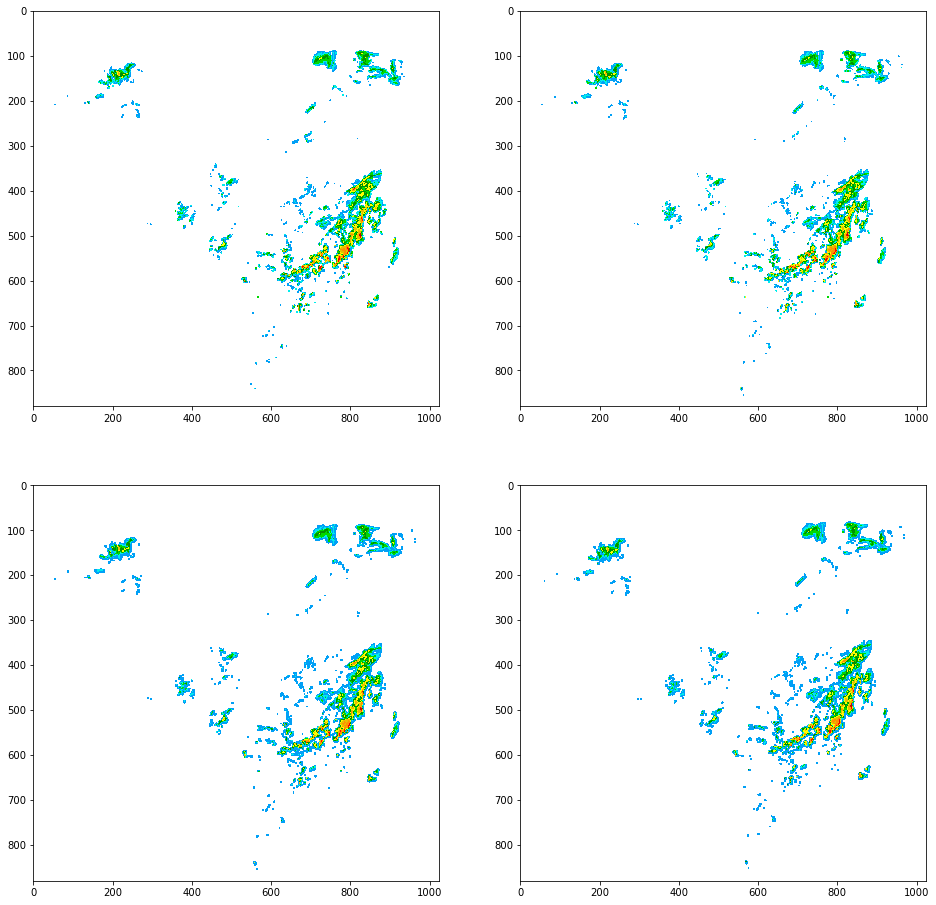

In [73]:
input = data_dict['202204250800'][0]
input = np.where(input == 0, np.nan, input)
nowcast = np.where(nowcast == 0, np.nan, nowcast)
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
ax1.pcolormesh(input[-2],cmap=icmap,vmin = 10, vmax = 75)
ax1.invert_yaxis()
ax2 = fig.add_subplot(222)
ax2.pcolormesh(input[-1],cmap=icmap,vmin = 10, vmax = 75)
ax2.invert_yaxis()
ax3 = fig.add_subplot(223)
ax3.pcolormesh(nowcast[0],cmap=icmap,vmin = 10, vmax = 75)
ax3.invert_yaxis()
ax4 = fig.add_subplot(224)
ax4.pcolormesh(nowcast[10],cmap=icmap,vmin = 10, vmax = 75)
ax4.invert_yaxis()

In [80]:
np.nanmax((nowcast[10]-nowcast[1]))

48.705882352941174

4.2 test the Sparse group for the setting period (eval_index)

In [11]:
optical_flow(data_dict, eval_idex, results, "SparseSD")

4.3 test the Dense group for a single time

In [82]:
time_extraplt = 202204250800
input_data = data_dict[str(time_extraplt)][0]

model = models.Dense()
model.of_method = "DIS"
model.interpolation = "linear"
model.input_data = input_data
model.scaler = RFScaler
model.inverse_scaler = inv_RFScaler
model.lead_steps = 10

nowcast = model.run()
print(nowcast.shape)

(12, 880, 1024)


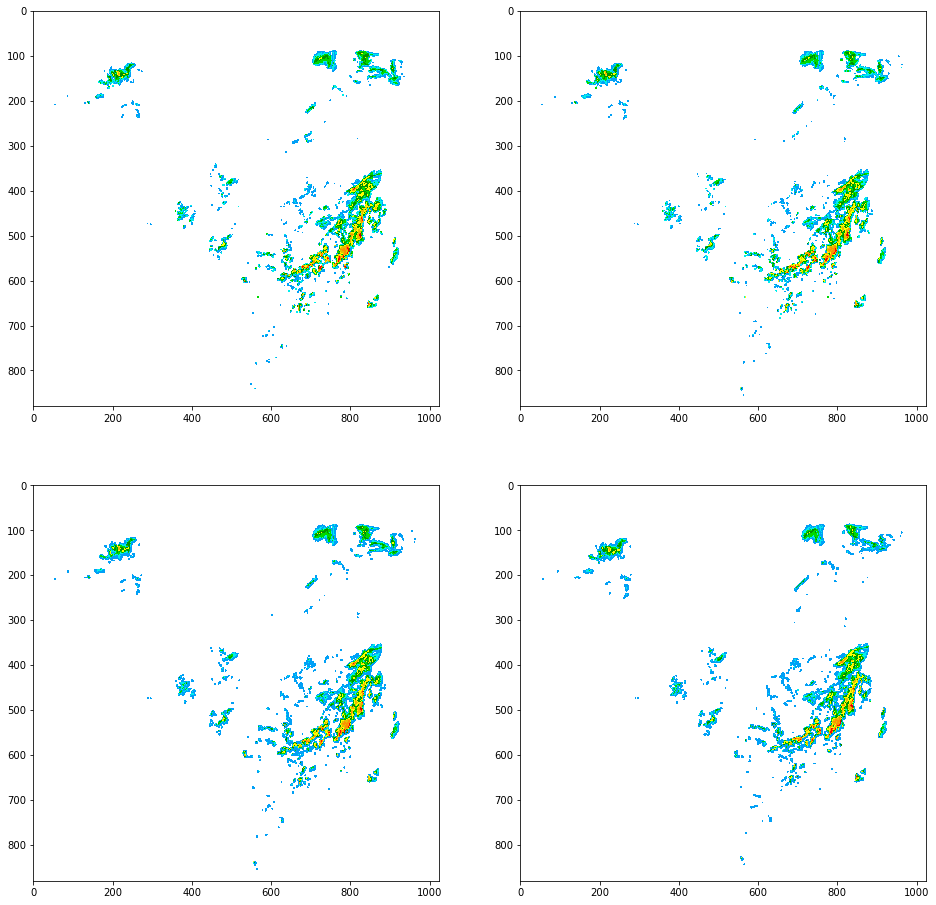

In [83]:
input = data_dict['202204250800'][0]
input = np.where(input == 0, np.nan, input)
nowcast = np.where(nowcast == 0, np.nan, nowcast)
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
ax1.pcolormesh(input[-2],cmap=icmap,vmin = 10, vmax = 75)
ax1.invert_yaxis()
ax2 = fig.add_subplot(222)
ax2.pcolormesh(input[-1],cmap=icmap,vmin = 10, vmax = 75)
ax2.invert_yaxis()
ax3 = fig.add_subplot(223)
ax3.pcolormesh(nowcast[0],cmap=icmap,vmin = 10, vmax = 75)
ax3.invert_yaxis()
ax4 = fig.add_subplot(224)
ax4.pcolormesh(nowcast[10],cmap=icmap,vmin = 10, vmax = 75)
ax4.invert_yaxis()

4.4 test the Dense group for the setting period (eval_index)

In [12]:
optical_flow(data_dict, eval_idex, results, "Dense") # around 1.64 min computational time for one time extrapolayion in average

4.5 create a benchmark for comparison. In the persistence group, results at any lead time is exact the same as the last image. 

In [15]:
def persistence(data_instance, eval_instance, results_instance):
    
    results_instance.create_group("/Persistence/")
    
    for key in sorted(list(eval_instance.keys())):
        
        inputs = np.array( data_instance[key][0] )
        
        model = models.Persistence()
        
        model.input_data = inputs
        
        nowcast = model.run()
        
        results_instance["/Persistence/"].create_dataset(key,
                                                         data=nowcast, 
                                                         dtype="float16",
                                                         compression="gzip")

In [16]:
%%time
persistence(data_dict, eval_idex, results)

Wall time: 4.43 s


In [144]:
results.keys()

<KeysViewHDF5 ['Dense', 'GT', 'Persistence', 'SparseSD']>

## 5. 来评估一下效果呢

In [17]:
# Verification block
def calculate_CSI(obs, sim, thresholds=[10,20,30,40]):
    
    result = {}
    
    for threshold in thresholds:
        result[str(threshold)] = [metrics.CSI(obs[i], sim[i], threshold=threshold) for i in range(obs.shape[0])]
    
    return result

def calculate_MAE(obs, sim):
    
    return [metrics.MAE(obs[i], sim[i]) for i in range(obs.shape[0])]

5.1 verification for a single time

Text(0.5, 1.0, 'CSI for 40 dBZ threshold')

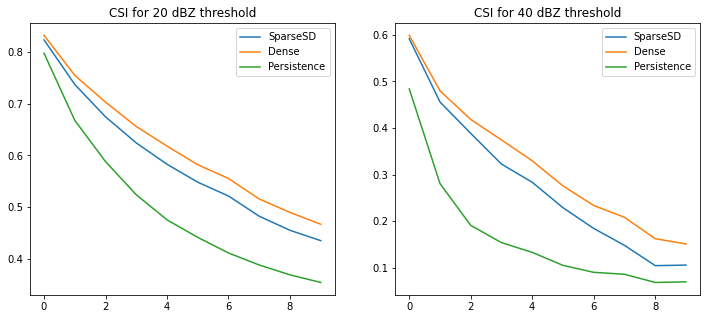

In [20]:
from collections import OrderedDict
metrics_dict = OrderedDict()
metrics_dict["SparseSD"] = OrderedDict()
metrics_dict["SparseSD"]["202204250700"] = {"SparseSD": {"CSI": None, "MAE": None}}

o = results["GT"]["202204250700"][()]
s = results["SparseSD"]["202204250700"][()]
s2= results["Dense"]["202204250700"][()]
s3= results["Persistence"]["202204250700"][()]
csi = calculate_CSI(o, s)
csi2 = calculate_CSI(o, s2)
csi3 = calculate_CSI(o, s3)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.plot(np.array(csi['20']),label = 'SparseSD')
ax1.plot(np.array(csi2['20']), label = 'Dense')
ax1.plot(np.array(csi3['20']), label = 'Persistence')
ax1.legend()
ax1.set_title('CSI for 20 dBZ threshold')

ax2 = fig.add_subplot(122)
ax2.plot(np.array(csi['40']),label = 'SparseSD')
ax2.plot(np.array(csi2['40']), label = 'Dense')
ax2.plot(np.array(csi3['40']), label = 'Persistence')
ax2.legend()
ax2.set_title('CSI for 40 dBZ threshold')

5.2 verification for the fulltime period

In [21]:
def calculate_metrics_dict(eval_instance, results_instance, 
                           model_names=["Persistence", "Sparse", "SparseSD", "Dense", "DenseRotation"]):
    
    metrics_dict = OrderedDict()
    
    for model_name in model_names:
        
        metrics_dict[model_name] = OrderedDict() #dict 里面又是一个dict
        
        for key in sorted(list(eval_instance.keys())):
            
            metrics_dict[model_name][key] = {model_name: {"CSI": None, "MAE": None}}
            
            # observed ground-truth
            o = results_instance["GT"][key][()]
            
            # results of nowcasting
            s = results_instance[model_name][key][()]
            
            metrics_dict[model_name][key][model_name]["CSI"] = calculate_CSI(o, s)
            metrics_dict[model_name][key][model_name]["MAE"] = calculate_MAE(o, s)
    
    return metrics_dict

In [22]:
metrics_dict = calculate_metrics_dict(eval_idex, results, model_names=[ "Persistence", "SparseSD", "Dense"])

In [23]:
np.save("results_metrics.npy", metrics_dict)

5.3 Vizualization of the verification

In [24]:
def MAE_simple_plot(metrics_dict, ax, axis=0):
    
    ### data preparation block ###
    event_name = "mosaic reflectivity in China"
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))
      
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))
    
    # create a holder for averaged MAE results
    mae = {model_name: None for model_name in model_names}
    
    for model_name in model_names:
        mae[model_name] = np.array( [metrics_dict[model_name][step][model_name]["MAE"] for step in main_keys] )
       
    ###   ###   ###
    t = range(6, 66, 6)
    
    #fig, ax = plt.subplots(figsize=(12, 8))
    
    for model in model_names:
        
        data = mae[model]
        
        data_to_plot = np.mean(data, axis=axis)
        
        ax.plot(t, data_to_plot, label=model)
    
    ax.grid(linestyle="--")
    ax.legend(fontsize=14)
    
    ax.set_title("{}: {} -- {}".format(event_name.title(), main_keys[0], main_keys[-1]), fontsize=16)
    ax.set_xlabel("Lead time, min", fontdict={"size": 16})
    ax.set_ylabel("MAE, dBZ", fontdict={"size": 16})
    
    ax.tick_params(labelsize=14)
    
    return ax

def CSI_simple_plot(metrics_dict, threshold, ax):
    
    """
    threshold should be a string from ['0.125', '0.25', '0.5', '1.0']
    """
    event_name = "mosaic reflectivity in China"
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))
    
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))
    
    # create a holder for averaged MAE results
    csi = {model_name: None for model_name in model_names}
    
    for model_name in model_names:
        csi[model_name] = np.array( [metrics_dict[model_name][step][model_name]["CSI"][threshold] for step in main_keys] )
    
    ###
    
    t = range(6, 66, 6)
         
    for model in model_names: 

        data = csi[model]
        data_to_plot = np.mean(data, axis=0)
        ax.plot(t, data_to_plot, label=model)

    ax.grid(linestyle="--")
    ax.legend(fontsize=14)
    
    ax.set_title("{}: {} -- {}, CSI threshold: {} dBZ".format(event_name.title(),
                                                               main_keys[0],
                                                               main_keys[-1],
                                                               threshold), 
                 fontsize=16)
    
    ax.set_xlabel("Lead time, min", fontdict={"size": 16})
    ax.set_ylabel("CSI", fontdict={"size": 16})
    
    ax.tick_params(labelsize=14)

    return ax

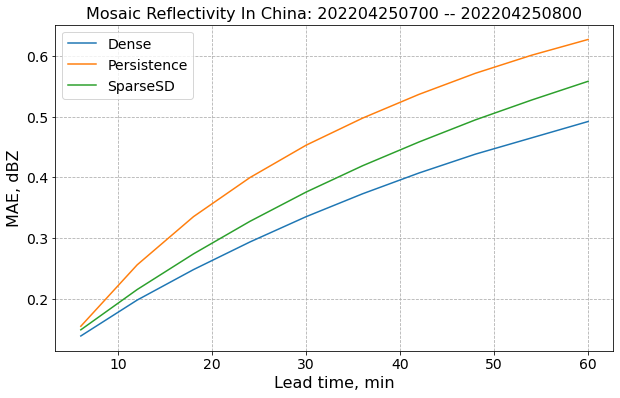

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ax = MAE_simple_plot(metrics_dict, ax)

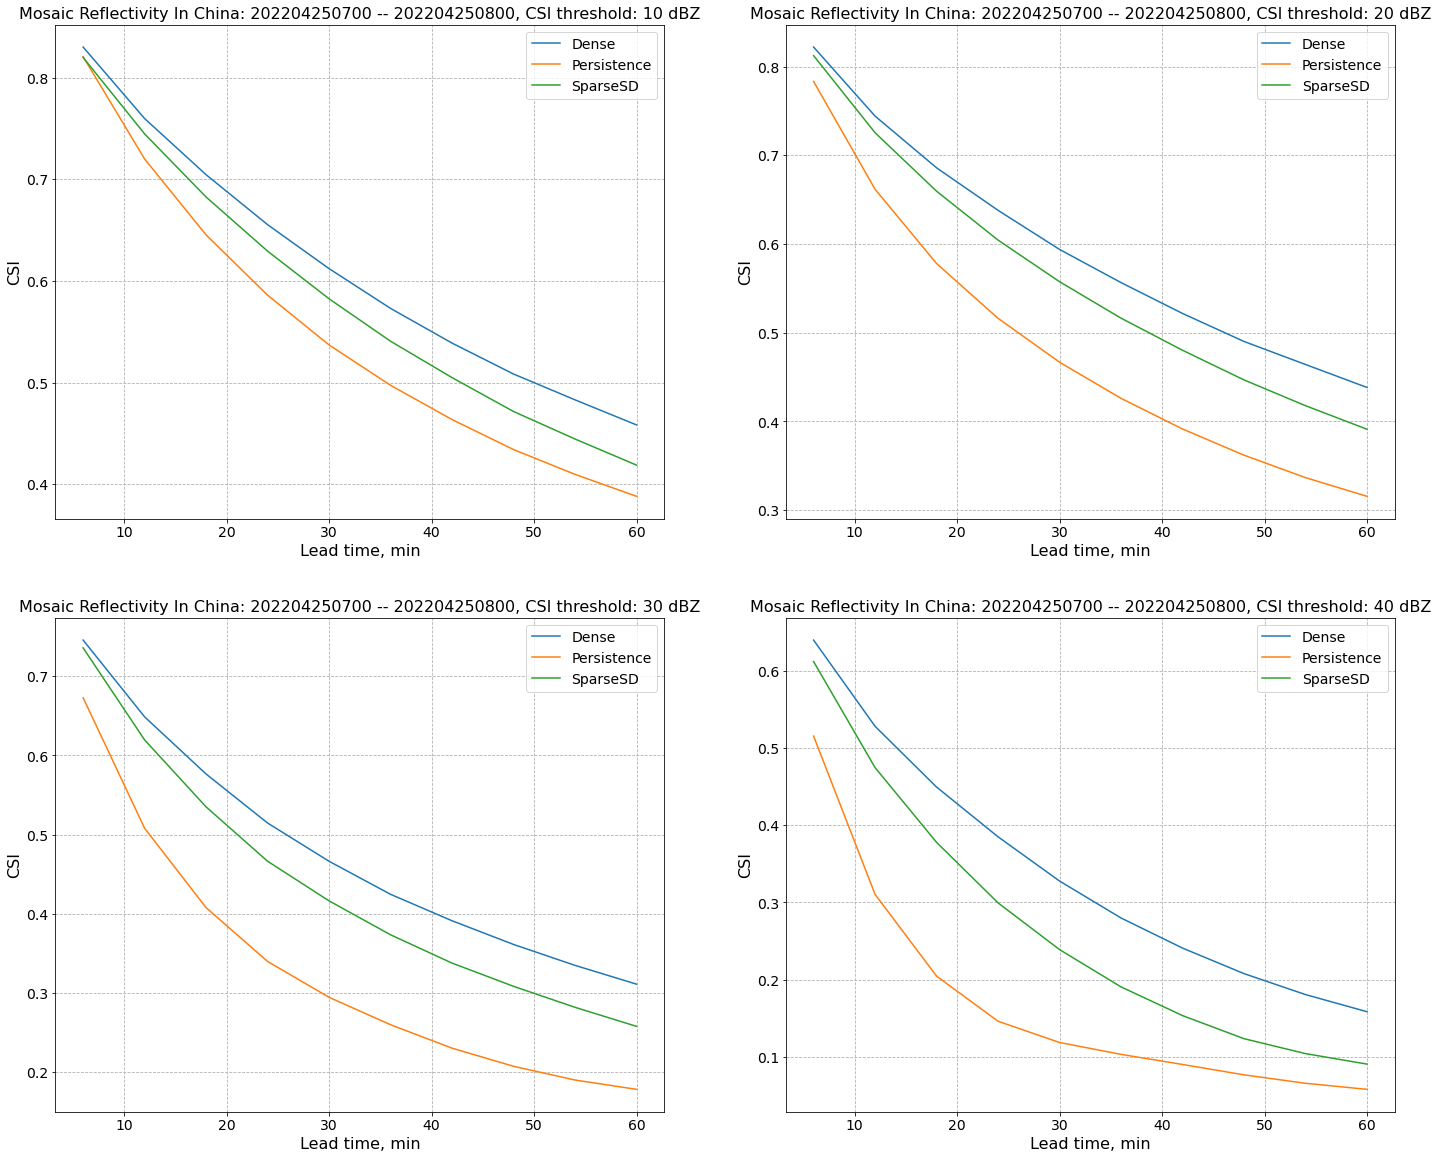

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(24,20))
axes = axes.ravel()
for i, threshold in enumerate(['10','20','30','40']):
    axes[i] = CSI_simple_plot(metrics_dict, threshold, axes[i])

## 6. 来，制作一组动图康康

6.1 test for a single time

(880, 1024, 3)
(880, 1024, 3)


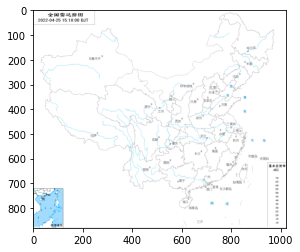

In [54]:
# 回顾一下画底图的流程，后面预测出来的回波需要加上这个底图信息

raw_img_array = plt.imread(r"E:/xiaowu\extrapolation\pic_ori/Z_RADA_C_BABJ_20220425071800_P_DOR_RDCP_R_ACHN.PNG")
rgb_img_array = (raw_img_array * 255).astype(np.uint8)
print(rgb_img_array.shape)

# 将底图与dbz颜色分离
flaw_img_array = copy.deepcopy(rgb_img_array)
data_img_array = copy.deepcopy(rgb_img_array)

for colors_array in colors_arrays:
    dist = np.sum((rgb_img_array - colors_array) ** 2, axis=2)
    dbz_index = np.where(dist==dist.min())              # dbz像素点对应的坐标
    flaw_img_array[dbz_index] = np.array([255,255,255]) # 有回波区域都填充为白色，白色的RGB为255 255 255
    
flaw_index = np.where(flaw_img_array.sum(axis=2)<255*3) # 非白色的坐标位置，即底图的坐标位置 

#画一下底图
plt.imshow(flaw_img_array)
#plt.axis("off")
print(flaw_img_array.shape)

In [13]:
results["SparseSD"]["202204250700"][()].shape

(10, 880, 1024)

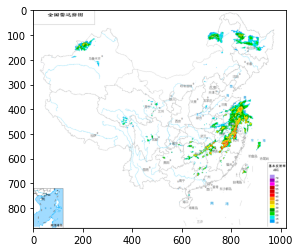

In [87]:
# 预测出来的回波去对应原图中的RGB数值
fcst = results["SparseSD"]["202204250700"][()][0]
image_arr = np.zeros(flaw_img_array.shape,dtype=float)
image_arr[:] = 255
for i, dbz_level in enumerate(dBZ_levels):
    dist = fcst - dbz_level
    dbz_index = np.where(np.abs(dist) <= 2.5 )
    image_arr[dbz_index] = colors_arrays[i]

image_arr[flaw_index] = flaw_img_array[flaw_index] 

#把图例加上
image_arr[upper_y:lower_y+1,left_x:right_x+1] = rgb_img_array[upper_y:lower_y+1,left_x:right_x+1]
#左上角的时间后面需要修改一下，先抠出来赋白色
image_arr[30:50,10:230] = 255
image_arr = image_arr/255.0

plt.imshow(image_arr)
#plt.axis("off")
plt.imsave("test2.png",image_arr)


6.2 批量处理 & 合并为动图

In [215]:
#读取一个示例文件，提取其底图信息
raw_img_array = plt.imread(r"E:/xiaowu\extrapolation\pic_ori/Z_RADA_C_BABJ_20220425071800_P_DOR_RDCP_R_ACHN.PNG")
rgb_img_array = (raw_img_array * 255).astype(np.uint8)

flaw_img_array = copy.deepcopy(rgb_img_array)
data_img_array = copy.deepcopy(rgb_img_array)

# 提取出底图及其坐标
for colors_array in colors_arrays:
    dist = np.sum((rgb_img_array - colors_array) ** 2, axis=2)
    dbz_index = np.where(dist==dist.min())
    flaw_img_array[dbz_index] = np.array([255,255,255])

def string_to_date(string: str) -> str:
    """字符串转日期格式"""
    from datetime import datetime
    shift_time = datetime.strptime(string, '%Y%m%d%H%M') # 字符串 -> 时间
    shift_date = shift_time.strftime("%Y-%#m-%#d %H:%M:%S") #时间 -> 任意时间格式; 前端不要自动补零，linux下前面加-，windows下前面加#
    return shift_date

def save_fcst_imag(path, eval_instance, results_instance, flaw_img_array = flaw_img_array, model_names = ["SparseSD", "Dense", "GT"]):
    from PIL import Image
    from PIL import ImageDraw
    from PIL import ImageFont
    myFont = ImageFont.truetype("simkai.ttf", 16)

    flaw_index = np.where(flaw_img_array.sum(axis=2)<255*3) 

    for model_name in model_names:
        for time_frame in sorted(list(eval_instance.keys())):
            animt = []
            for n_time in range(0,10):
                fcst = results_instance[model_name][time_frame][()][n_time]
                image_arr = np.zeros(flaw_img_array.shape,dtype=float)
                image_arr[:] = 255
                for i, dbz_level in enumerate(dBZ_levels):
                    dist = fcst - dbz_level
                    dbz_index = np.where(np.abs(dist) <= 2.5 )
                    image_arr[dbz_index] = colors_arrays[i]
    
                image_arr[flaw_index] = flaw_img_array[flaw_index] 

                #把图例加上
                image_arr[upper_y:lower_y+1,left_x:right_x+1] = rgb_img_array[upper_y:lower_y+1,left_x:right_x+1]
                #修改左上角的时间
                image_arr[30:50,10:230] = 255
                image_arr = image_arr/255.0


                # 存储为临时的图片，下面会直接在这个图片上加一些文字信息
                plt.imsave("intern_imag.png",image_arr)

                # add text to image
                img = Image.open('intern_imag.png')
                I1 = ImageDraw.Draw(img)
                
                shift_date = string_to_date(str(time_frame))
                #print(time_frame, shift_date)
                I1.text((5, 35), shift_date+" BJT +" +str(( n_time + 1 )*6) + " min",font=myFont, fill=(0, 0, 0))
                I1.text((500, 35), model_name, font=myFont, fill=(0, 0, 0))
                # save image
                animt.append(img)
                # 如果需要存储单张图片可以把下面的注释取消
                #img.save(path + model_name + "_" + time_frame + "_" + str(( n_time + 1 ) * 6) + "_min_fcst.png")
                #plt.imsave(model_name+"_"+time_frame+"_"+str(( n_time + 1 )*6)+"_min_fcst.png",image_arr)
            
            animt[0].save(path + model_name + "_" + time_frame +".gif", save_all=True, append_images=animt[1:], duration = 500) #in milliseconds, https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html
            print(model_name + "_" + time_frame + ": animation finished!")

In [216]:
path = 'E:/xiaowu/extrapolation/pic_ori/'
save_fcst_imag(path = path, eval_instance = eval_idex,results_instance = results, model_names = ["SparseSD", "Dense", "GT"])

SparseSD_202204250700: animation finished!
SparseSD_202204250706: animation finished!
SparseSD_202204250712: animation finished!
SparseSD_202204250718: animation finished!
SparseSD_202204250724: animation finished!
SparseSD_202204250730: animation finished!
SparseSD_202204250736: animation finished!
SparseSD_202204250742: animation finished!
SparseSD_202204250748: animation finished!
SparseSD_202204250754: animation finished!
SparseSD_202204250800: animation finished!
Dense_202204250700: animation finished!
Dense_202204250706: animation finished!
Dense_202204250712: animation finished!
Dense_202204250718: animation finished!
Dense_202204250724: animation finished!
Dense_202204250730: animation finished!
Dense_202204250736: animation finished!
Dense_202204250742: animation finished!
Dense_202204250748: animation finished!
Dense_202204250754: animation finished!
Dense_202204250800: animation finished!
GT_202204250700: animation finished!
GT_202204250706: animation finished!
GT_2022042507

6.3 观测和预测结合起来展示

In [192]:
# two gifs stack test 
import imageio

#Create reader object for the gif
gif1 = imageio.get_reader(path+'Dense_202204250700.gif')
gif2 = imageio.get_reader(path+'GT_202204250700.gif')

#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#Create writer object
new_gif = imageio.get_writer('output.gif', duration=0.5) # the duration is in unit of second.

for frame_number in range(number_of_frames):
    img1 = gif1.get_next_data()
    img2 = gif2.get_next_data()
    #here is the magic
    new_image = np.hstack((img1, img2))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()    
new_gif.close()

In [272]:
from statistics import quantiles

def horizontal_gifs(gifs: list, outfile : str, duration = 0.5):
    gif = []
    for frame in gifs:
        gif.append( imageio.get_reader(frame) )
    
    number_of_frames = min( [i_gif.get_length() for i_gif in gif] )

    #Create writer object
    new_gif = imageio.get_writer(outfile, duration=0.5)    

    for frame_number in range(number_of_frames): #10 帧
        img = [gif[i].get_next_data() for i in range(len(gifs))]
        new_image = np.hstack((img[i] for i in range(len(gifs)) ))
        new_gif.append_data(new_image)

In [273]:
for time_frame in sorted(list(eval_idex.keys())):
    gifs = [path + model_name + "_" + time_frame + ".gif" for model_name in ["GT", "SparseSD", "Dense"] ]
    print(gifs)
    out_file = path + "GT_fcsts_" + time_frame + ".gif"
    horizontal_gifs(gifs, out_file)

['E:/xiaowu/extrapolation/pic_ori/GT_202204250700.gif', 'E:/xiaowu/extrapolation/pic_ori/SparseSD_202204250700.gif', 'E:/xiaowu/extrapolation/pic_ori/Dense_202204250700.gif']


<ipython-input-272-5c160bfb0fe6>:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  new_image = np.hstack((img[i] for i in range(len(gifs)) ))


['E:/xiaowu/extrapolation/pic_ori/GT_202204250706.gif', 'E:/xiaowu/extrapolation/pic_ori/SparseSD_202204250706.gif', 'E:/xiaowu/extrapolation/pic_ori/Dense_202204250706.gif']
['E:/xiaowu/extrapolation/pic_ori/GT_202204250712.gif', 'E:/xiaowu/extrapolation/pic_ori/SparseSD_202204250712.gif', 'E:/xiaowu/extrapolation/pic_ori/Dense_202204250712.gif']
['E:/xiaowu/extrapolation/pic_ori/GT_202204250718.gif', 'E:/xiaowu/extrapolation/pic_ori/SparseSD_202204250718.gif', 'E:/xiaowu/extrapolation/pic_ori/Dense_202204250718.gif']
['E:/xiaowu/extrapolation/pic_ori/GT_202204250724.gif', 'E:/xiaowu/extrapolation/pic_ori/SparseSD_202204250724.gif', 'E:/xiaowu/extrapolation/pic_ori/Dense_202204250724.gif']
['E:/xiaowu/extrapolation/pic_ori/GT_202204250730.gif', 'E:/xiaowu/extrapolation/pic_ori/SparseSD_202204250730.gif', 'E:/xiaowu/extrapolation/pic_ori/Dense_202204250730.gif']
['E:/xiaowu/extrapolation/pic_ori/GT_202204250736.gif', 'E:/xiaowu/extrapolation/pic_ori/SparseSD_202204250736.gif', 'E:/xiao

以上就生成了gif格式的动画，本想在notebook中展示一下，可它就是动不了，有缘再来看吧~

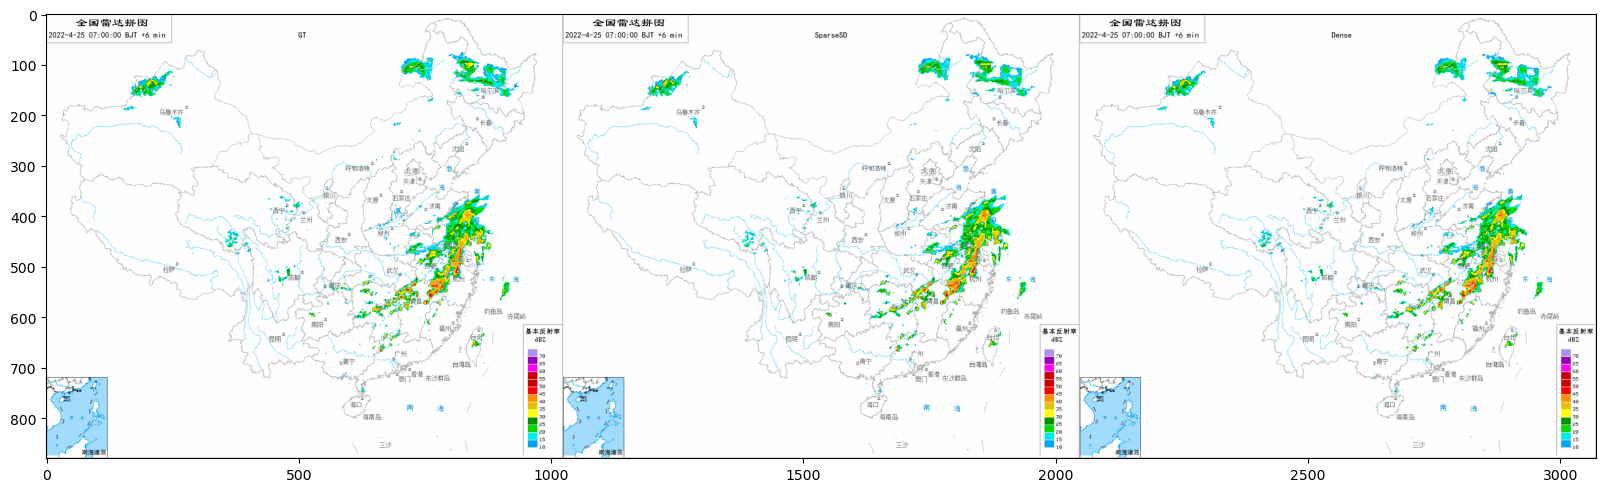

In [269]:
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.image as mplimage

gif = imageio.get_reader(path+"GT_fcsts_202204250700.gif")
number_of_frames = gif.get_length()
fig, ax = plt.subplots(figsize=(20,8),dpi = 100)
for frame_number in range(number_of_frames-1):
    img = gif.get_next_data()
    #ax.cla()
    display.clear_output(wait=True)#每次显示完图以后删除，达到显示动图的效果
    #print(type(img), img.shape)
    ax.imshow(img)
    #ax.axis("off")
    plt.pause(0.5)#每次显示图片的暂停时间